In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, auc, roc_curve, f1_score, r2_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error


from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras import layers
from datetime import datetime
from keras.datasets import mnist
from keras.layers import Dense, LSTM

In [3]:
# CLUSTER 0
df = pd.read_excel("Walmart_clusters.xlsx")
class_0 = df[df["cluster_sklearn"] == 2]

In [4]:
x1 = pd.to_numeric(class_0["Weekly_Sales"], errors="coerce").to_numpy()
x11= pd.to_numeric(class_0["Holiday_Flag"], errors="coerce").to_numpy()
x2 = pd.to_numeric(class_0["Temperature"], errors="coerce").to_numpy()
x3 = pd.to_numeric(class_0["Fuel_Price"], errors="coerce").to_numpy()
x4 = pd.to_numeric(class_0["CPI"], errors="coerce").to_numpy()
x5 = pd.to_numeric(class_0["Unemployment"], errors="coerce").to_numpy()
x6 = pd.to_numeric(class_0["yyyy"], errors="coerce").to_numpy()
x7 = pd.to_numeric(class_0["mm"], errors="coerce").to_numpy()
x8 = pd.to_numeric(class_0["dd"], errors="coerce").to_numpy()
x9 = pd.to_numeric(class_0["week_absolute"], errors="coerce").to_numpy()
x10 = pd.to_numeric(class_0["Date"], errors="coerce").to_numpy()

In [5]:
scaler = MinMaxScaler()

x_list = [x1, x11, x2, x3, x4, x5, x6, x7, x9]
features = []

for i in x_list:
    i = scaler.fit_transform(i.reshape(-1,1))
    features.append(i)
    x = np.concatenate(features,  axis=1)


In [6]:
# zamiana danych na sekwencję, wymagają tego warstwy rekurencyjne
# długość sekwencji zależy od tego po jakiej ilości próbek w czasie chcemy aby rekurencja chodziła
def ConvertDataToSequence(data, windowLen, featNum):
    """
    :param data: dane w postaci szeregu, typu numpy.array, shape=(N,Feat)
    :param windowLen: długość okna czyli długość sekwencji
    :param featNum: ilość cech w ramach szeregu
    """
    #długość wejściowego szeregu
    lenOfAllSeq = data.shape[0]
    # pusty kontener na kolejne sekwencje
    xSeq = []
    # idziemy po szeregu i tworzymy z niego sekwencje
    for i in range(lenOfAllSeq-windowLen):
        xSeq.append(data[i:i+windowLen])
    xSeq = np.array(xSeq).reshape(-1,windowLen,featNum)
    
    # definiujemy wartości następujące po każdej sekwencji, będą to nasze wyjścia
    y = data[windowLen:,0].reshape(-1,1)
    
    return xSeq, y

In [7]:
seqLen = 6
featNum = 9
xSeq, y = ConvertDataToSequence(x, seqLen, featNum)
print(f"sequence shape: {xSeq.shape}")
print(f"output shape: {y.shape}")

sequence shape: (2668, 6, 9)
output shape: (2668, 1)


In [8]:
test_percent = 0.1

In [9]:
x_len = xSeq.shape[0]

In [10]:
x_train_num = int(x_len*(1.0-test_percent))
x_test_num = int(x_len*test_percent)

In [11]:
xSeq_train = xSeq[:x_train_num]
xSeq_test = xSeq[-x_test_num:]

In [12]:
y_train = y[:x_train_num]
y_test = y[-x_test_num:]

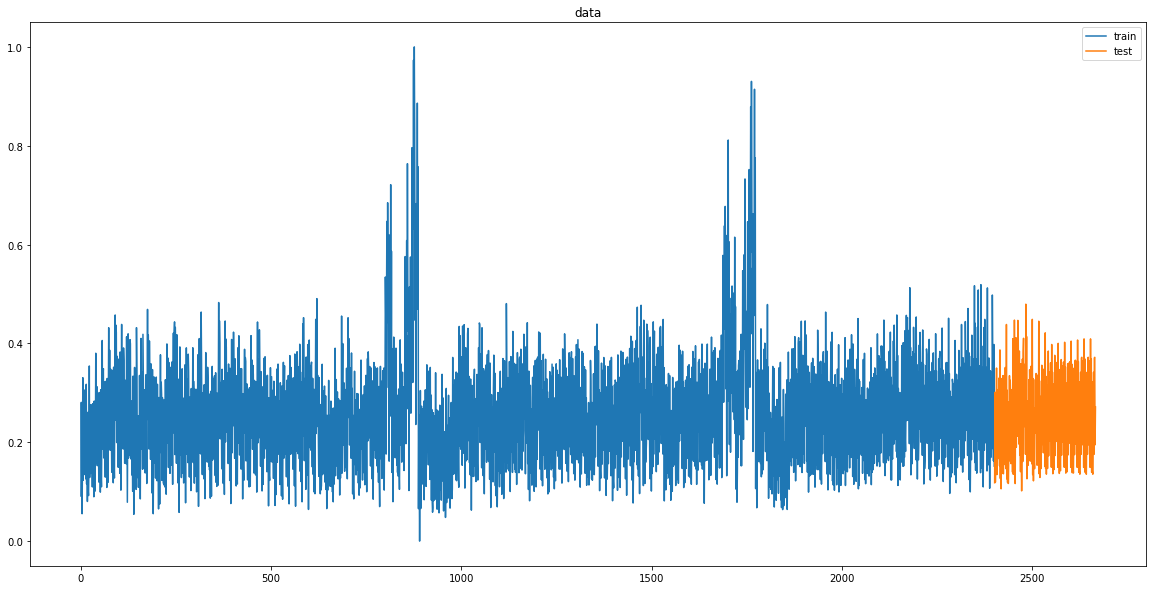

In [13]:
fig = plt.figure(figsize=(20,10))
plt.plot(np.arange(x_train_num), xSeq_train[:,0,0])
plt.plot(np.arange(x_train_num, x_len-1), xSeq_test[:,0,0])
plt.legend(["train","test"])
plt.title("data")
plt.show()

In [14]:
modelRNN = tf.keras.Sequential()

modelRNN.add(
    layers.LSTM(
        units=128,
        input_shape=(seqLen, featNum),
        name="rekurencja_pierwsza",
        return_sequences=True
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.LSTM(
        units=128,
        name="rekurencja_druga"
    )
)

modelRNN.add(
    layers.Dense(
        units=128,
        activation="relu"
    )
)

modelRNN.add(
    layers.Dropout(0.0)
)

modelRNN.add(
    layers.Dense(
        units=1,
        name="wyjscie"
    )
)

modelRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rekurencja_pierwsza (LSTM)  (None, 6, 128)            70656     
                                                                 
 dropout (Dropout)           (None, 6, 128)            0         
                                                                 
 rekurencja_druga (LSTM)     (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 wyjscie (Dense)             (None, 1)                 129       
                                                                 
Total params: 218,881
Trainable params: 218,881
Non-trai

In [15]:
modelRNN.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="mse"
)

In [16]:
history = modelRNN.fit(
    x=xSeq_train,
    y=y_train,
    epochs=20,
    batch_size=4,
    validation_data=(xSeq_test, y_test),
    
)

Epoch 1/20
601/601 [==============================] - 11s 12ms/step - loss: 0.0136 - val_loss: 0.0077
Epoch 2/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0113 - val_loss: 0.0071
Epoch 3/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0094 - val_loss: 0.0070
Epoch 4/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0062 - val_loss: 0.0079
Epoch 5/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0040 - val_loss: 0.0046
Epoch 6/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 7/20
601/601 [==============================] - 6s 11ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/20
601/601 [==============================] - 6s 10ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 9/20
601/601 [==============================] - 7s 12ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 10/20
601/601 [==============================] - 7s 12ms/step - loss: 0.0022 - val_l

In [17]:
y_pred = modelRNN.predict(xSeq_test)

In [18]:
print(mean_squared_error(y_test,y_pred))
print(r2_score(y_test,y_pred))
print(mean_absolute_percentage_error(y_test,y_pred))

0.0012782050837541988
0.8619943001807143
0.10829005560175975


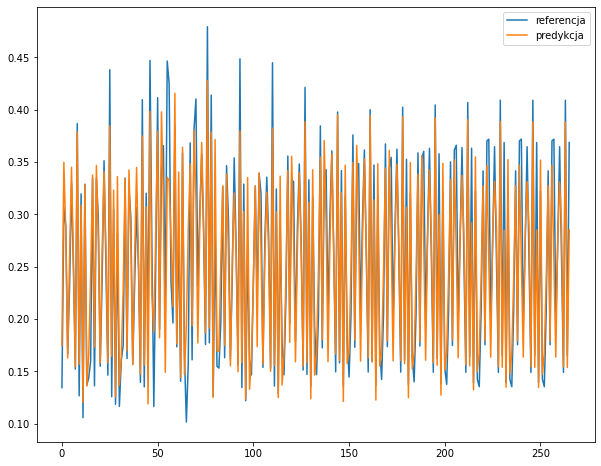

In [19]:
fig = plt.figure(figsize=(10,8))
plt.plot(y_test)
plt.plot(y_pred.reshape(-1))

plt.legend(["referencja", "predykcja"])
plt.show()

In [19]:
rev_trans = scaler.inverse_transform(y_pred)

In [20]:
modelRNN.save("Projekt_DL/model_2.h5")

In [19]:
modelRNN.save("model/model_k2.h5")

In [21]:
modelRNN.save("/Users/Dell/Desktop/kurs_data_science/DL/DL PROJEKT/app_clusters/modele_klastry/model_k2.h5")

In [22]:
dataset = pd.DataFrame(data=list(zip(y_pred[:11], y_test[:11])))

In [23]:
dataset

,0,1
0,[0.17467317],[0.13447584699682713]
1,[0.3497783],[0.30650720019976996]
2,[0.28430584],[0.2892884816818797]
3,[0.16274354],[0.16692082687210436]
4,[0.258466],[0.2329368751828762]
5,[0.34508917],[0.32969757159454716]
6,[0.25829998],[0.2480511471997423]
7,[0.1544117],[0.15218588896185403]
8,[0.3788361],[0.3868402517329754]
9,[0.1567668],[0.126689490253115]
